# Example notebook for offline calculation of condensation rates

This notebook shows how to use the functions in **microphysics_functions.py** to approximate condensation rates from hourly 3D standard WRF output. This approximation is based on the assumption that any change in supersaturation is balanced by condensation (saturated conditions are maintained).  

Additional assumptions: 
- changes in water vapor (qv) and temperature (T) from processes other than condensation and vertical velocity (e.g. mixing, radiation) can be neglected for deep convective systems
- deposition can can be neglected (> 90 % of condensation+deposition comes from condensation in idealized MCS simulations)

In [2]:
import numpy as np
import datetime
import pandas as pd 
import xarray as xr
import wrf
from netCDF4 import Dataset
from pathlib import Path
import microphysics_functions as micro
import warnings
warnings.filterwarnings("ignore") 

#### Read in WRF model output 

In [24]:
path = Path('/glade/campaign/mmm/c3we/prein/Idealized_MCSs/wrfout_files/WRF/19_2011-07-13_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5/4000')
fname = path / 'wrfout_d01_0001-01-01_03:00:00'
ds = xr.open_dataset(filename)
wrf_ds = Dataset(fname)

# get necessary variables
vertical_velocity = wrf.getvar(wrf_ds, 'wa')
temp = wrf.getvar(wrf_ds, 'tk')
pressure = wrf.getvar(wrf_ds, 'pres')
qcloud = ds.QCLOUD.squeeze()
base_pressure = ds.PB.squeeze()

#### Derive condensation rate for one timestep (in kg/kg/s)

In [25]:
condensation_rate_t= micro.get_condensation_rate(vertical_velocity, temp, pressure, base_pressure)

#create a cloud mask, because equation is conditional for grid cells where qcloud > 0 
condensation_cloud = condensation_rate_t.where(qcloud > 0, 0) 
# moreover, we are only interested in positive values, as negative values are evaporation 
condensation_masked = condensation_cloud.where(condensation_cloud > 0, 0 ).data
# integrate over pressure levels to get kg/m2/s
condensation_rate = micro.pressure_integration(condensation_masked, -pressure.data)


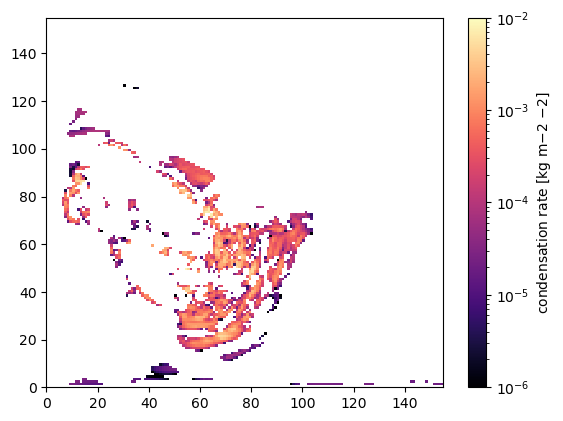

In [31]:
import matplotlib.pyplot as plt 
from matplotlib.colors import LogNorm
plt.pcolormesh(condensation_rate, norm = LogNorm(1e-6, 1e-2), cmap = 'magma')
plt.colorbar(label = 'condensation rate [kg m${-2}$ ${-2}$]') 
plt.show()